# Constants and Libraries

## Only if needed

import os

# Login with tenant ID
os.system("az login --tenant 3ad0b905-34ab-4116-93d9-c1dcc2d35af6 --output none")

# Set the subscription programmatically
os.system("az account set --subscription eca2eddb-0f0c-4351-a634-52751499eeea")

In [1]:
import os
from IPython.display import Markdown, display
from dotenv import load_dotenv # requires python-dotenv
from PIL import Image # requires pip install pillow
from datetime import datetime
from common.agents_helper_functions import *
import importlib.metadata
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

if not load_dotenv("./../config/credentials_my.env"):
    print("Environment variables not loaded, cell execution stopped")
else:
    print("Environment variables have been loaded ;-)")


deployment_name =  os.environ["MODEL_DEPLOYMENT_NAME_MINI"]
api_version = os.environ["OPENAI_API_VERSION"] # at least "2025-03-01-preview"

print(f'Project Connection String: <...{os.environ["PROJECT_CONNECTION_STRING"][-30:]}>')
version = importlib.metadata.version("azure-ai-projects")
print(f"azure-ai-projects library installed version: {version}")

Environment variables have been loaded ;-)
Project Connection String: <...hub01-grp;mmai-swc-hub01-prj01>
azure-ai-projects library installed version: 1.0.0b10


# Create AI Foundry Project Client

In [2]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(), 
    conn_str=os.environ["PROJECT_CONNECTION_STRING"]
)

project_client.scope

{'subscription_id': 'eca2eddb-0f0c-4351-a634-52751499eeea',
 'resource_group_name': 'mmai-swc-hub01-grp',
 'project_name': 'mmai-swc-hub01-prj01'}

# Just for testing: List current AI Foundry Agents

In [3]:
agents = project_client.agents.list_agents()
agents

{'object': 'list', 'data': [], 'first_id': None, 'last_id': None, 'has_more': False}

In [4]:
# easier to read ;-)

[f"{a.id}: {a.name}" for a in agents.data]

[]

# Create the CodeInterpreterTool

In [5]:
from azure.ai.projects.models import CodeInterpreterTool

code_interpreter = CodeInterpreterTool()
print(f"Code interpreter definitions: {code_interpreter.definitions}")
print(f"Code interpreter resources: {code_interpreter.resources}")

Code interpreter definitions: [{'type': 'code_interpreter'}]
Code interpreter resources: {}


# Create AI Foundry Agent with its CodeInterpreterTool for AI Agents

In [6]:
# ...then, create the AI Foundry Agent, attaching CodeInterpreterTool object
ai_agent = project_client.agents.create_agent(
    model=deployment_name,
    name="my-agent001",
    instructions="You are a helpful agent",
    tools=code_interpreter.definitions,
    tool_resources=code_interpreter.resources,
)

ai_agent.items

<bound method _MyMutableMapping.items of {'id': 'asst_he9jQwRofFsNOhFpsWbdhywK', 'object': 'assistant', 'created_at': 1748478185, 'name': 'my-agent001', 'description': None, 'model': 'gpt-4o-mini', 'instructions': 'You are a helpful agent', 'tools': [{'type': 'code_interpreter'}], 'top_p': 1.0, 'temperature': 1.0, 'tool_resources': {'code_interpreter': {'file_ids': []}}, 'metadata': {}, 'response_format': 'auto'}>

# Just for testing: create a new agent and delete it

In [7]:
# Create a second agent
ai_agent_02 = project_client.agents.create_agent(
    model=deployment_name,
    name="my-agent002 TO BE DELETED",
    instructions="You are a helpful agent",
    tools=code_interpreter.definitions,
    tool_resources=code_interpreter.resources,
)

# List all agents
print(f"All agents, including the useless one:")
display([f"{a.id}: {a.name}" for a in project_client.agents.list_agents()['data']])

project_client.agents.delete_agent(ai_agent_02.id)

# List all agents
print(f"\nAll agents, after deleting the useless one:")
display([f"{a.id}: {a.name}" for a in project_client.agents.list_agents()['data']])

All agents, including the useless one:


['asst_CuoOokaSPoDgizyhh9b6gSV3: my-agent002 TO BE DELETED',
 'asst_he9jQwRofFsNOhFpsWbdhywK: my-agent001']


All agents, after deleting the useless one:


['asst_he9jQwRofFsNOhFpsWbdhywK: my-agent001']

# Create the thread and attach a new message to it

In [8]:
# Create a thread
thread = project_client.agents.create_thread()

print(f"Created thread: {thread}\n")

# Add a user message to the thread
message = project_client.agents.create_message(
    thread_id=thread.id,
    role="user",
    content="""
    Could you please create a bar chart for the operating profit using 
    the following data and provide the file to me? 
    Company A: $1.2 million, Company B: $2.5 million, Company C: $3.0 million, 
    Company D: $1.8 million
    """,
)
print(f"Messages: {project_client.agents.list_messages(thread_id=thread.id)}")

Created thread: {'id': 'thread_ogfAurrrpYbwLuVAqSDhatZK', 'object': 'thread', 'created_at': 1748478188, 'metadata': {}, 'tool_resources': {}}

Messages: {'object': 'list', 'data': [{'id': 'msg_vM0vJGqTEwGZMWvBQ4PiHdXt', 'object': 'thread.message', 'created_at': 1748478188, 'assistant_id': None, 'thread_id': 'thread_ogfAurrrpYbwLuVAqSDhatZK', 'run_id': None, 'role': 'user', 'content': [{'type': 'text', 'text': {'value': '\n    Could you please create a bar chart for the operating profit using \n    the following data and provide the file to me? \n    Company A: $1.2 million, Company B: $2.5 million, Company C: $3.0 million, \n    Company D: $1.8 million\n    ', 'annotations': []}}], 'attachments': [], 'metadata': {}}], 'first_id': 'msg_vM0vJGqTEwGZMWvBQ4PiHdXt', 'last_id': 'msg_vM0vJGqTEwGZMWvBQ4PiHdXt', 'has_more': False}


# Run the agent syncrhonously

In [9]:
%%time

# Run the agent
run = project_client.agents.create_and_process_run\
    (thread_id=thread.id, agent_id=ai_agent.id)

# print(f"Run status: {run.status}.\n\nRun details: {run}")

CPU times: user 26.9 ms, sys: 2.24 ms, total: 29.1 ms
Wall time: 9.72 s


# Fetch messages from the thread after the agent run execution

In [10]:
from azure.ai.projects.models import MessageTextContent, MessageImageFileContent

if run.status == 'completed':    
    messages = project_client.agents.list_messages(thread_id=thread.id)
    messages_nr = len(messages.data)
    print(f"Here are the {messages_nr} messages:\n")
    
    for i, message in enumerate(reversed(messages.data), 1):
        j = 0
        print(f"\n===== MESSAGE {i} =====")
        for c in message.content:
            j +=1
            if (type(c) is MessageImageFileContent):
                print(f"\nCONTENT {j} (MessageImageFileContent) --> image_file id: {c.image_file.file_id}")
            elif (type(c) is MessageTextContent):
                print(f"\nCONTENT {j} (MessageTextContent) --> Text: {c.text.value}")
                for a in c.text.annotations:
                    print(f">>> Annotation in MessageTextContent {j} of message {i}: {a.text}\n")

else:
    print(f"Sorry, I can't proceed because the run status is {run.status}")

Here are the 2 messages:


===== MESSAGE 1 =====

CONTENT 1 (MessageTextContent) --> Text: 
    Could you please create a bar chart for the operating profit using 
    the following data and provide the file to me? 
    Company A: $1.2 million, Company B: $2.5 million, Company C: $3.0 million, 
    Company D: $1.8 million
    

===== MESSAGE 2 =====

CONTENT 1 (MessageImageFileContent) --> image_file id: assistant-SBK8aUZhggWgA9i7C4FRN5

CONTENT 2 (MessageTextContent) --> Text: The bar chart for the operating profits of the companies has been created. You can download the file using the link below:

[Download Operating Profit Chart](sandbox:/mnt/data/operating_profit_chart.png)
>>> Annotation in MessageTextContent 2 of message 2: sandbox:/mnt/data/operating_profit_chart.png



# Retrieve and download eventual annotations

Nr. of file path annotations: 1

1 - File annotation paths: {'type': 'file_path', 'text': 'sandbox:/mnt/data/operating_profit_chart.png', 'start_index': 158, 'end_index': 202, 'file_path': {'file_id': 'assistant-3sfPW8pfmEmv1N43C4SGtH'}}
File annotation 1 saved as file to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dsvm-mem-optimized04/code/Users/mauro.minella/git_repos/aaas/operating_profit_chart.png


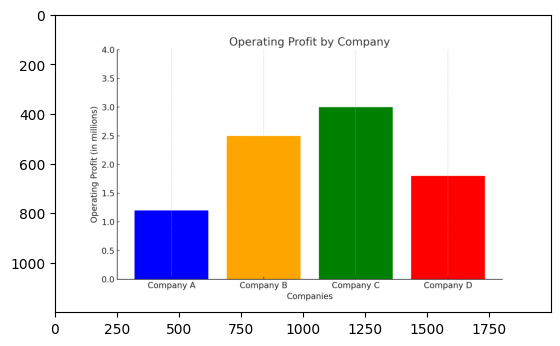

In [11]:
# messages.file_path_annotations[0].text.split('/')[-1]
print (f"Nr. of file path annotations: {len(messages.file_path_annotations)}\n")

i=0
for file_path_annotation in messages.file_path_annotations:
    i += 1
    print(f"{i} - File annotation paths: {file_path_annotation}")
    file_name = file_path_annotation.text.split('/')[-1]
    project_client.agents.save_file(file_id=file_path_annotation.file_path.file_id, file_name=file_name)
    print(f"File annotation {i} saved as file to: {os.getcwd()}/{file_name}")
    image = mpimg.imread(f"{os.getcwd()}/{file_name}") # read the image
    plt.imshow(image)
    plt.show()

# Retrieve and download eventual images

Nr. of image contents: 1

1 - Image content: {'type': 'image_file', 'image_file': {'file_id': 'assistant-SBK8aUZhggWgA9i7C4FRN5'}}
Image content 1 file to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dsvm-mem-optimized04/code/Users/mauro.minella/git_repos/aaas/assistant-SBK8aUZhggWgA9i7C4FRN5_image_content.png


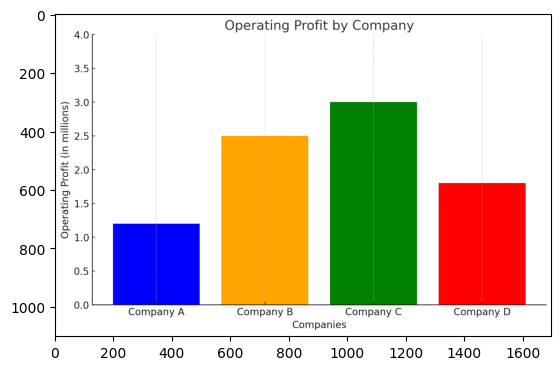

In [12]:
print (f"Nr. of image contents: {len(messages.image_contents)}\n")

i=0
# Generate an image file for the bar chart
for image_content in messages.image_contents:
    i += 1
    print(f"{i} - Image content: {image_content}")
    file_name = f"{image_content.image_file.file_id}_image_content.png"
    project_client.agents.save_file(file_id=image_content.image_file.file_id, file_name=file_name)
    print(f"Image content {i} file to: {os.getcwd()}/{file_name}")
    image = mpimg.imread(f"{os.getcwd()}/{file_name}") # read the image
    plt.imshow(image)
    plt.show()

# Collect **all** resources for this project

In [13]:
all_agents = list_all_agents(project_client=project_client)
print(all_agents["summary"])

all_threads = list_all_threads(project_client)
print(all_threads["summary"])

all_files = list_all_files(project_client)
print(all_files["summary"])

all_runs = list_all_runs(project_client)
print(all_runs["summary"])

all_runsteps=list_all_runsteps(project_client)
print(all_runsteps["summary"])

all_messages = list_all_messages(project_client)
print(all_messages["summary"])

all_vectorstores = list_all_vectorstores(project_client=project_client)
print(all_vectorstores["summary"])

1 agents in project <mmai-swc-hub01-prj01>
1 threads in project <mmai-swc-hub01-prj01>
2 files in project <mmai-swc-hub01-prj01>
1 runs in 1 threads of project <mmai-swc-hub01-prj01>
2 run steps in 1 pairs of (thread, run) of project <mmai-swc-hub01-prj01>
2 messages in 1 threads of project <mmai-swc-hub01-prj01>
0 vector stores in project <mmai-swc-hub01-prj01>


# Teardown for **all** resources

In [14]:
# delete all vector stores

i=0
for vector_store in all_vectorstores["content"]["data"]:
    i += 1
    project_client.agents.delete_vector_store(vector_store_id=vector_store.id)
    print(f"{i} - Vector store <{vector_store.id}> has been deleted")

all_vectorstores = list_all_vectorstores(project_client=project_client)

print(f"Vector stores deleted: {i}\n")

Vector stores deleted: 0



In [15]:
# delete all files

i=0
for file in all_files['content']['data']:
    i += 1
    project_client.agents.delete_file(file_id=file.id)
    print(f"{i} - File <{file.filename}> ({file.id}) has been deleted")

all_files = list_all_files(project_client)

print(f"Files deleted: {i}\n")

1 - File </mnt/data/operating_profit_chart.png> (assistant-3sfPW8pfmEmv1N43C4SGtH) has been deleted
2 - File <3f7e8d21-7aee-454b-9c71-925f4bc84005.png> (assistant-SBK8aUZhggWgA9i7C4FRN5) has been deleted
Files deleted: 2



In [16]:
# delete all threads

i=0
for thread in all_threads["content"]["data"]:
    i += 1
    project_client.agents.delete_thread(thread_id=thread.id)
    print(f"{i} - Thread <{thread.id}> has been deleted")

all_threads = list_all_threads(project_client)

print(f"Threads deleted: {i}\n")

1 - Thread <thread_ogfAurrrpYbwLuVAqSDhatZK> has been deleted
Threads deleted: 1



In [17]:
# delete all agents

i=0
for agent in all_agents["content"]["data"]:
    i += 1
    project_client.agents.delete_agent(agent_id=agent.id)
    print(f"{i} - Agent <{agent.id}> has been deleted")

all_agents = list_all_agents(project_client=project_client)

print(f"Agents deleted: {i}\n")

1 - Agent <asst_he9jQwRofFsNOhFpsWbdhywK> has been deleted
Agents deleted: 1



# HIC SUNT LEONES